In [13]:
# Data Manipulation
import pandas as pd
import numpy as np

# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
# from xgboost import XGBClassifier

# Model Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

# Dimensionality Reduction (if needed)
from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Warnings
import warnings
warnings.filterwarnings('ignore')


In [14]:
df = pd.read_csv("sentinel_features_for_modeling.csv")
print(df.head())

# Identify and print the names of all columns that have categorical (object) data types.
# This is useful for knowing which features may need encoding before modeling.
print("\nCategorical columns:", df.select_dtypes(include='object').columns)

   step      type     amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0    19  CASH_OUT  156435.77  C1306155018            0.0             0.0   
1     9  CASH_OUT  159022.13  C1970395543       100332.0             0.0   
2    35  CASH_OUT  281322.81   C870758580        11308.0             0.0   
3    38  CASH_OUT   63142.96  C2094408841            0.0             0.0   
4    41  CASH_OUT  370542.50   C730868144        10054.0             0.0   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  balance_shift_diff  \
0    C10389336       350075.23       329337.60        0            20737.63   
1  C1875625456            0.00       159022.13        0           -58690.13   
2  C1388202553       107819.35       389142.16        0          -270014.81   
3   C221397311        73531.14       136674.10        0           -63142.96   
4   C849704466       281294.97       651837.47        0          -360488.50   

   balanced  log_amount  log_oldbalanceOrg  log_oldbalanceDest  \
0 

In [15]:
# Drop the 'nameOrig' and 'nameDest' columns, which are identifiers for sender and receiver.
# These columns are not useful for modeling because they don't carry predictive information and may add noise.
df = df.drop(['nameOrig', 'nameDest'], axis=1)

# Convert the 'type' categorical column into dummy/one-hot encoded variables.
# 'drop_first=True' avoids multicollinearity by dropping the first category (acts as a baseline).
df = pd.get_dummies(df, columns=['type'], drop_first=True)

# Ensure the 'balanced' column is stored as integers (0 or 1) instead of boolean or float.
# This is important for consistent handling in modeling tasks like classification.
df['balanced'] = df['balanced'].astype(int)


In [16]:
# Drop columns related to raw transaction amounts and balances.
# These columns may leak information or be highly correlated, which can hurt model performance.
df = df.drop(['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest'], axis=1)

# Separate features (X) and target variable (y).
# 'isFraud' is the label we want to predict, so it's removed from the features.
X = df.drop("isFraud", axis=1)
y = df["isFraud"]

# Apply standard scaling to the feature set.
# StandardScaler standardizes features by removing the mean and scaling to unit variance,
# which helps many machine learning models perform better.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert the scaled features back into a DataFrame with original column names for readability.
print(X_scaled.head())

       step  balance_shift_diff  balanced  log_amount  log_oldbalanceOrg  \
0 -0.549320            0.336710 -0.337025   -0.035886          -1.073048   
1 -1.093793            0.222469 -0.337025   -0.022580           1.023838   
2  0.321838           -0.081480 -0.337025    0.440331           0.626375   
3  0.485181            0.216064 -0.337025   -0.772085          -1.073048   
4  0.648523           -0.211609 -0.337025    0.663864           0.604975   

   log_oldbalanceDest  log_newbalanceOrig  log_newbalanceDest  type_TRANSFER  
0            0.359267           -0.311789           -0.023994       -0.52644  
1           -2.065589           -0.311789           -0.233701       -0.52644  
2            0.135569           -0.311789            0.024069       -0.52644  
3            0.062867           -0.311789           -0.277323       -0.52644  
4            0.317717           -0.311789            0.172656       -0.52644  


In [17]:
# Split the data into training and testing sets.
# Use stratified sampling to preserve the original fraud/non-fraud ratio in both sets.
# 20% of the data is reserved for testing; random_state ensures reproducibility.
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Save the training and testing sets to CSV files.
# This allows for easy reuse later without needing to repeat preprocessing steps.
X_train.to_csv("X_train.csv", index=False)
X_test.to_csv("X_test.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

# Print the shapes of the training and test feature sets to confirm the split.
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

# Check the class distribution in the training and test labels.
# Ensures stratified sampling preserved the fraud class balance across sets.
print("y_train distribution:\n", y_train.value_counts(normalize=True))
print("y_test distribution:\n", y_test.value_counts(normalize=True))


X_train shape: (800, 9)
X_test shape: (200, 9)
y_train distribution:\n isFraud
0    0.9
1    0.1
Name: proportion, dtype: float64
y_test distribution:\n isFraud
0    0.9
1    0.1
Name: proportion, dtype: float64


Class distribution in full dataset (y):
isFraud
0    900
1    100
Name: count, dtype: int64

Class balance (percentages):
isFraud
0    90.00%
1    10.00%
Name: proportion, dtype: object


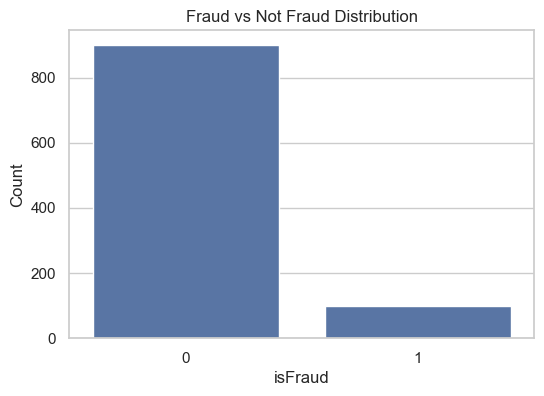

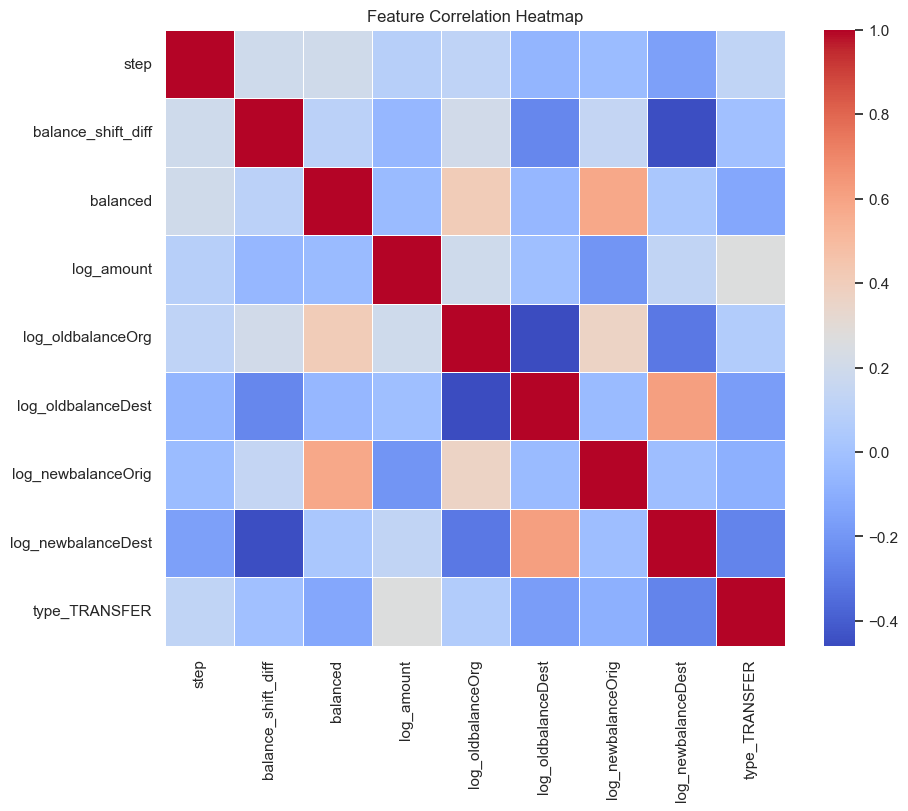

In [20]:
# Display the count of each class in the target variable `y`.
# This helps us understand how imbalanced the dataset is (e.g., number of fraud vs non-fraud cases).
print("Class distribution in full dataset (y):")
print(y.value_counts())

# Display class distribution as percentages for better interpretation of imbalance.
print("\nClass balance (percentages):")
print(y.value_counts(normalize=True).apply(lambda x: f"{x:.2%}"))

# Import seaborn and matplotlib for visualizations.
import seaborn as sns
import matplotlib.pyplot as plt

# Set seaborn style for cleaner plots.
sns.set(style="whitegrid")

# Create a bar plot to visualize the distribution of fraud vs. non-fraud cases.
# This helps visualize class imbalance.
plt.figure(figsize=(6,4))
sns.countplot(x=y)
plt.title("Fraud vs Not Fraud Distribution")
plt.xlabel("isFraud")
plt.ylabel("Count")
plt.show()

# Create a heatmap to visualize correlation between features.
# This helps identify redundant features or strong linear relationships.
plt.figure(figsize=(10,8))
sns.heatmap(X.corr(), cmap="coolwarm", annot=False, linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()
